In [1]:
from google.colab import files
token = files.upload()

Saving kaggle (2).json to kaggle (2).json


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install -q kaggle

In [7]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 99% 156M/158M [00:01<00:00, 90.4MB/s]
100% 158M/158M [00:01<00:00, 95.8MB/s]


In [8]:
!unzip -q covid19-image-dataset.zip

In [9]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_data_path = "/content/Covid19-dataset/train"
test_data_path = "/content/Covid19-dataset/test"

size of image (h x w) 3480 4248


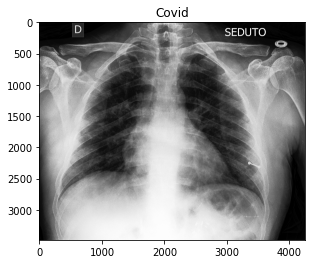

In [16]:
img = plt.imread(os.path.join(train_data_path, "Covid/01.jpeg"))
plt.imshow(img)
height, width, dim = img.shape
plt.title('Covid')
print("size of image (h x w)",height,width)

size of image (h x w) 1333 1582


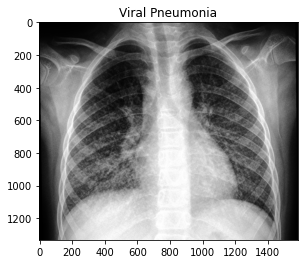

In [17]:
img = plt.imread(os.path.join(train_data_path, "Viral Pneumonia/01.jpeg"))
plt.imshow(img)
height, width, dim = img.shape
plt.title('Viral Pneumonia')
print("size of image (h x w)",height,width)

size of image (h x w) 1708 1944


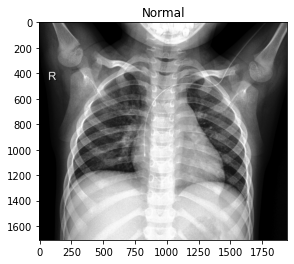

In [18]:
img = plt.imread(os.path.join(train_data_path, "Normal/01.jpeg"))
plt.imshow(img)
height, width, dim = img.shape
plt.title('Normal')
print("size of image (h x w)",height,width)

In [19]:
##image augmentaion
train = ImageDataGenerator(rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
train_dataset = train.flow_from_directory(train_data_path,
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'categorical',shuffle=True)

Found 251 images belonging to 3 classes.


In [20]:
train_dataset.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [21]:
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPool2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPool2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(3,activation='softmax'))
benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

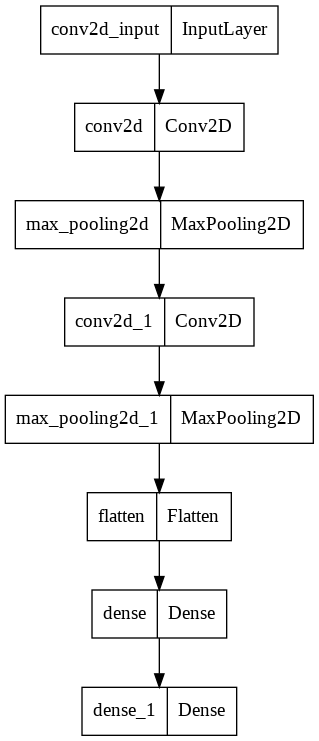

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(benchmark_model)

In [23]:
#Using callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
modelcheck = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [24]:
history = benchmark_model.fit(train_dataset, 
                    epochs=30,
                    callbacks=[modelcheck,reduce_lr,early_stopping],
                    batch_size=32)

Epoch 1/30
8/8 [==============================] - 19s 1s/step - loss: 1.5999 - acc: 0.3267 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 11s 1s/step - loss: 1.1044 - acc: 0.4582 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 11s 1s/step - loss: 1.0328 - acc: 0.6056 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - 11s 1s/step - loss: 0.8547 - acc: 0.7331 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 11s 1s/step - loss: 0.6396 - acc: 0.7610 - lr: 0.0010
Epoch 6/30
8/8 [==============================] - 11s 1s/step - loss: 0.4900 - acc: 0.8526 - lr: 0.0010
Epoch 7/30
8/8 [==============================] - 11s 1s/step - loss: 0.4883 - acc: 0.8367 - lr: 0.0010
Epoch 8/30
8/8 [==============================] - 11s 1s/step - loss: 0.3681 - acc: 0.8805 - lr: 0.0010
Epoch 9/30
8/8 [==============================] - 11s 1s/step - loss: 0.4728 - acc: 0.8207 - lr: 0.0010
Epoch 10/30
8/8 [==============================] - 11s 1s/step -

In [25]:
accuracy = history.history['acc']
loss = history.history['loss']

Text(0, 0.5, 'Accuracy')

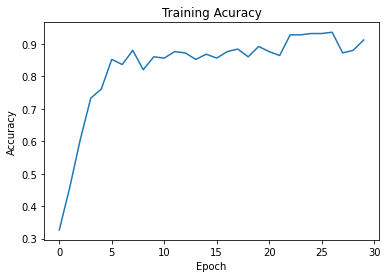

In [26]:
plt.title('Training Acuracy')
sns.lineplot(data=accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

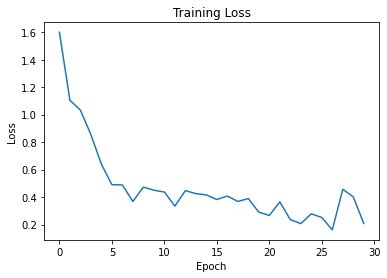

In [27]:
plt.title('Training Loss')
sns.lineplot(data=loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [28]:
test = ImageDataGenerator(rescale=1/255)                                       
test_dataset = test.flow_from_directory(test_data_path,target_size=(150, 150),batch_size=32,shuffle=False)
test_steps_per_epoch = np.math.ceil(test_dataset.samples / test_dataset.batch_size)

predictions = benchmark_model.predict(test_dataset, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

Found 66 images belonging to 3 classes.


In [29]:
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys()) 

In [30]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.93      1.00      0.96        26
         Normal       1.00      0.90      0.95        20
Viral Pneumonia       0.90      0.90      0.90        20

       accuracy                           0.94        66
      macro avg       0.94      0.93      0.94        66
   weighted avg       0.94      0.94      0.94        66



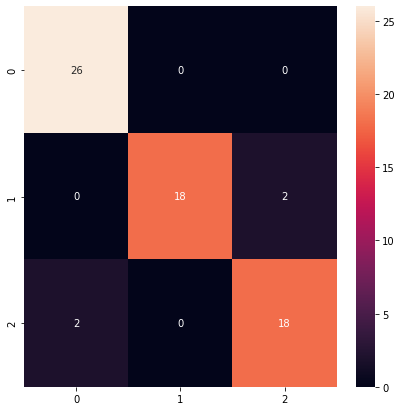

In [31]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True)